# Analysis of SPIR case using *wavpy*

We will see an example of how to estimate iGNSS-R altimetry delay from a 10-sec interval of the SPIR dataset. The purpose of this excercise is to illustrate several capabilities of *wavpy*, including beamformer computation, alignment of waveform series (usually refered among us as retracking) and use of *Waveform_complex_cluster* and *Waveform_power* classes.

First, list of imports:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
HOME = os.getenv("HOME")
wavpyDIR = HOME + "/gnssr_analysis/trunk/src/waveform_pylib/wavpy/"
sys.path.insert(1,wavpyDIR)
import wavpy

Now we define the variables required:

In [2]:
#Phase offsets previously estimated for both arrays (required for the beamformer)
phases_offset = np.zeros(16)
phases_offset[0] = 0.00
phases_offset[1] = 146.92
phases_offset[2] = -146.96
phases_offset[3] = -147.47
phases_offset[4] = -176.24
phases_offset[5] = -155.03
phases_offset[6] = -152.11
phases_offset[7] = 171.89
phases_offset[8] = 0.00
phases_offset[9] = 84.24
phases_offset[10] = 76.38
phases_offset[11] = 118.13
phases_offset[12] = 117.05
phases_offset[13] = 100.82
phases_offset[14] = -23.70
phases_offset[15] = 76.34

#Position of antenna elements at the antenna reference frame
pos_elems = np.zeros([8,2])
pos_elems[0][0] = -0.1651
pos_elems[0][1] = -0.03808
pos_elems[1][0] = -0.1651
pos_elems[1][1] = 0.07622
pos_elems[2][0] = -0.0508
pos_elems[2][1] = -0.03808
pos_elems[3][0] = -0.0508
pos_elems[3][1] = 0.07622
pos_elems[4][0] = 0.0635
pos_elems[4][1] = -0.03808
pos_elems[5][0] = 0.0635
pos_elems[5][1] = 0.07622
pos_elems[6][0] = 0.1778
pos_elems[6][1] = -0.03808
pos_elems[7][0] = 0.1778
pos_elems[7][1] = 0.07622

#RF_FrontEnd object accounting for the up-looking array
receiver_UP = wavpy.RF_FrontEnd()
receiver_UP.set_antenna_orientation_BF_EH([1.0, 0.0, 0.0], [0.0, -1.0, 0.0]) #Up-looking antenna
receiver_UP.set_antenna_elements_pos_AF(pos_elems, 0)

#RF_FrontEnd object accounting for the down-looking array
receiver_DW = wavpy.RF_FrontEnd()
receiver_DW.set_antenna_elements_pos_AF(pos_elems, 0)

#Specular_geometry object to compute geometry aspects
mygeom = wavpy.Specular_geometry()
mygeom.load_sp3File("data/igs18734.sp3", 'G')

#Position of up-looking array in the aircraft body frame
pos_array_UP_BF = np.zeros(3)
pos_array_UP_BF[0] = -1.21
pos_array_UP_BF[1] = 0.122
pos_array_UP_BF[2] = -0.01

#Position of down-looking array in the aircraft body frame
pos_array_DW_BF = np.zeros(3)
pos_array_DW_BF[0] = -1.23
pos_array_DW_BF[1] = 0.093
pos_array_DW_BF[2] = 2.093

#Sampling rate in Hz (samples/sec)
sampling_rate = 80000000.0

#Size of resulting waveform in samples
size_wav = 512

#Coherent time of integration in msecs
coh_msecs = 1

#Starting time reference
gps_week = 1873
init_sow = 384780

#GPS PRN number selected
prn = 1

#ascii file containing inertial information
inert_filename = "data/week_sow_roll_pitch_yaw_TEST.txt"

#ascii file containing the precise position of the receiver
recpos_filename = "data/week_sow_posR_ECEF_TEST.txt"

#Waveform_power object to average power waveforms after aligning them with delay information
wav_pow = wavpy.Waveform_power()
wav_pow.set_sampling_rate(sampling_rate)
wav_pow.set_min_resolution_fft_interp(0.05)
wav_pow.set_fit_length(5.0)

#Waveform_power object to average power waveforms without delay alignment for comparison purposes
wav_pow_notAlign = wavpy.Waveform_power()
wav_pow_notAlign.set_sampling_rate(sampling_rate)
wav_pow_notAlign.set_min_resolution_fft_interp(0.05)
wav_pow_notAlign.set_fit_length(5.0)

#Waveform_complex_cluster to collect raw SPIR data and compute complex waveforms
mywavCluster = wavpy.Waveform_complex_cluster()

At this point we perform the integration loops (uncoherent and coherent). A delay model is computed at every time sample with the ancillary information available in order to align the power waveforms prior to their averaging. From such information we also compute the required phases to apply a beamformer for obtaining the complex waveforms from the raw samples contained at the SPIR data files.

Note: You will need to have direct network connection to dumbo in order to be able to read the SPIR files.

In [3]:
for sow in np.arange(init_sow, init_sow + 10):
    
    print "In sow %d" % (sow)
    
    #We compute the delay evolution at msec-level during the whole second (998 samples for SPIR)
    retracking_msec = np.zeros(999)
    for msec in range(999):
        #Geometry delay
        mygeom.read_ECEFpos_GNSS_Transmitter_sp3Loaded(gps_week, float(sow) + float(msec)/1000.0, prn, 'G')
        mygeom.read_ECEFpos_Receiver(recpos_filename, gps_week, float(sow) + float(msec)/1000.0)
        mygeom.compute_specular_point(0)
        #Inertial delay
        mygeom.read_Inertials_Receiver(inert_filename, gps_week, float(sow) + float(msec)/1000.0)
        pos_array_UP_Local = mygeom.rotate_vector_BF_to_local(pos_array_UP_BF)
        pos_array_DW_Local = mygeom.rotate_vector_BF_to_local(pos_array_DW_BF)
        inertial_delay = (pos_array_DW_Local[1] - pos_array_UP_Local[1])*(np.cos(mygeom.elevation*np.pi/180.0)) + (pos_array_DW_Local[2] - pos_array_UP_Local[2])*(-np.sin(mygeom.elevation*np.pi/180.0)) #Projection over reflected signal path
        #Atmospheric delay
        posR_LLH = mygeom.get_LongLatHeight_Receiver()
        atmospheric_delay = (4.6/np.sin(mygeom.elevation*np.pi/180.0))*(1.0 - np.exp(-posR_LLH[2]/8.621))
                
        if(msec == 0):
            #The delay model at zero msec is taken as a reference 
            ref_range = mygeom.geometric_delay*1000.0 - inertial_delay + atmospheric_delay
            #We compute at this point the phases that are needed to later apply the beamformer
            posS_ECEF = mygeom.get_ECEFpos_Specular()
            posR_ECEF = mygeom.get_ECEFpos_Receiver()
            posT_ECEF = mygeom.get_ECEFpos_Transmitter()
            inert_RPY = mygeom.get_inertials()
            receiver_UP.compute_phase_delays_pos_ECEF_RT(inert_RPY, posR_ECEF, posT_ECEF)
            receiver_DW.compute_phase_delays_pos_ECEF_RT(inert_RPY, posR_ECEF, posS_ECEF)
            phase_delaysUP = receiver_UP.get_phase_delays(8)
            phase_delaysDW = receiver_DW.get_phase_delays(8)
            phasesUP = (phase_delaysUP*180.0/np.pi) - phases_offset[0:8]
            phasesDW = (phase_delaysDW*180.0/np.pi) - phases_offset[8:16]
            if(sow == init_sow):
                ref_elev_initsow = mygeom.elevation
        
        #We store the delay correction for sub-second waveform alignment
        retracking_msec[msec] = ref_range - (mygeom.geometric_delay*1000.0 - inertial_delay + atmospheric_delay)

    #SPIR file for given sow    
    spir_file_name = "/home/dumbo/dades/SPIR-Campaign-2015-12-03/SPIR-data-ThirdFlight_20151203/L1ant_20151203_104938/00Hour/03Min/" + str(sow - init_sow + 1).zfill(2) + "Sec"    
    #Here we get 1-sec of SPIR raw data and we load 998 complex waveforms after applying a beamformer with the phases previously computed
    #This function is by far the step that requires the highest computational cost
    start_window_delay = mywavCluster.load_ITF_waveforms_SPIR(spir_file_name, ref_range, phasesUP, phasesDW, 0)
    
    #Integration of complex waveforms (coherently until coh_msecs, then uncoherently until 1-sec) applying delay alignment
    wav_int = mywavCluster.integrate_waveforms_retracking(coh_msecs, sampling_rate, retracking_msec, size_wav)
    #Integration of complex waveforms (coherently until coh_msecs, then uncoherently until 1-sec) without delay alignment
    wav_int_notAlign = mywavCluster.integrate_waveforms(coh_msecs, size_wav)
    
    if(sow == init_sow):
        #First sow is the time reference
        ref_swd_initsow = start_window_delay
        ref_range_initsow = ref_range
        #We load the power waveform from the first sow
        wav_pow.set_init_range(start_window_delay)
        wav_pow.set_waveform(wav_int)
        #We also load the same power waveform from the first sow here
        wav_pow_notAlign.set_init_range(start_window_delay)
        wav_pow_notAlign.set_waveform(wav_int_notAlign)
    else:
        #The next power waveforms are added after applying a delay displacement (retracking)
        wav_pow.add_waveform_retracking(wav_int, ref_range_initsow - ref_range + start_window_delay - ref_swd_initsow, 1.0/float(sow-init_sow), False)
        #Here we add the next waveforms but only applying the displacement given by possible changes in the assigment of the initial start window delay
        wav_pow_notAlign.add_waveform_retracking(wav_int_notAlign, start_window_delay - ref_swd_initsow, 1.0/float(sow-init_sow), False)

    
mygeom.free_sp3File()
print "Done!"

In sow 384780
In sow 384781
In sow 384782
In sow 384783
In sow 384784
In sow 384785
In sow 384786
In sow 384787
In sow 384788
In sow 384789
Done!


Now we compare the integrated power waveforms obtained by plotting them:

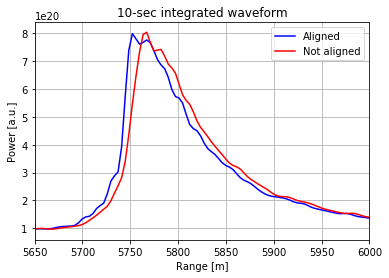

In [4]:
plt.plot(wav_pow.get_range_waveform(size_wav), wav_pow.get_waveform(size_wav), 'b-', label="Aligned")
plt.plot(wav_pow_notAlign.get_range_waveform(size_wav), wav_pow_notAlign.get_waveform(size_wav), 'r-', label="Not aligned")
plt.xlim([5650, 6000])
plt.xlabel("Range [m]")
plt.ylabel("Power [a.u.]")
plt.title("10-sec integrated waveform")
plt.legend()
plt.grid()
plt.show()

We can see how the waveform averaged without delay alignment spreads further in the range axis.

Finally, we will compute the altimetry delay for both cases.

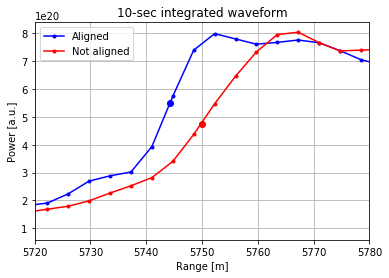

Altimetry delay difference: 5.74 m


In [5]:
wav_pow.compute_delays()
plt.plot(wav_pow.get_range_waveform(size_wav), wav_pow.get_waveform(size_wav), 'b.-', label="Aligned")
plt.plot(wav_pow.positionDer, wav_pow.power_posDer, 'bo')
wav_pow_notAlign.compute_delays()
plt.plot(wav_pow_notAlign.get_range_waveform(size_wav), wav_pow_notAlign.get_waveform(size_wav), 'r.-', label="Not aligned")
plt.plot(wav_pow_notAlign.positionDer, wav_pow_notAlign.power_posDer, 'ro')
plt.xlim([5720, 5780])
plt.xlabel("Range [m]")
plt.ylabel("Power [a.u.]")
plt.title("10-sec integrated waveform")
plt.legend()
plt.grid()
plt.show()

print "Altimetry delay difference: %3.2f m" % (wav_pow_notAlign.positionDer - wav_pow.positionDer)

We can make a first estimation of the ellipsoidal sea surface height (SSH) obtained with both waveforms:

In [8]:
print "SSH (wavs. aligned) = %3.2f m" % ((ref_range_initsow - wav_pow.positionDer)/(2.0*np.sin(ref_elev_initsow*np.pi/180.0)))
print "SSH (wavs. not aligned) = %3.2f m" % ((ref_range_initsow - wav_pow_notAlign.positionDer)/(2.0*np.sin(ref_elev_initsow*np.pi/180.0)))

SSH (wavs. aligned) = 17.18 m
SSH (wavs. not aligned) = 14.17 m


According to in-situ measurements, the SSH at this location and time was 17.41 m, a value which is clearly closer to the result obtained after applying waveform alignment.